In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Data Preprocessing
Preprocess the data: normalize pixels, resized images and one hot encode.

Split the data into training, test and validation sets


In [ ]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# preprocessing
def preprocess(image, label, target_height=224, target_width=224):
    image = tf.image.resize(image, (target_height, target_width))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values

    # One-Hot encode
    def to_categorical_wrapper(x):
        return tf.keras.utils.to_categorical(x.numpy(), num_classes=dataset_info.features['label'].num_classes)

    label = tf.py_function(to_categorical_wrapper, [label], tf.float32)
    label.set_shape((dataset_info.features['label'].num_classes,))

    return image, label

num_classes = dataset_info.features['label'].num_classes

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

train_size = int(0.8 * dataset_info.splits['train'].num_examples)
val_size = dataset_info.splits['train'].num_examples - train_size

train_dataset, val_dataset = train_dataset.take(train_size), train_dataset.skip(train_size)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteCDKBWV/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteCDKBWV/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## Create CNN models + Model Training and Optimization
Resnet50, Alexnet, custom model and InceptionV3

Experimented with different layers, parameters and fine tuning to achieve best possible results.

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the end layers for better customization
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# ResNet50-based model
resnet_model = Model(inputs=base_model.input, outputs=output)

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create an optimizer with the learning rate scheduler
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement callbacks
resnet_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
resnet_model_checkpoint = ModelCheckpoint('resnet_best_model.h5', save_best_only=True)

# Train the ResNet50-based model
history_resnet = resnet_model.fit(
    train_dataset.batch(64),
    epochs=20,
    validation_data=val_dataset.batch(64),
    callbacks=[resnet_early_stopping, resnet_model_checkpoint]
)

Epoch 1/20
150/150 [==============================] - 172s 948ms/step - loss: 4.7834 - accuracy: 0.0136 - val_loss: 4.7891 - val_accuracy: 0.0092
Epoch 2/20
150/150 [==============================] - 134s 896ms/step - loss: 4.6167 - accuracy: 0.0185 - val_loss: 4.7908 - val_accuracy: 0.0088
Epoch 3/20
150/150 [==============================] - 133s 888ms/step - loss: 4.4541 - accuracy: 0.0293 - val_loss: 151.4365 - val_accuracy: 0.0083
Epoch 4/20
150/150 [==============================] - 132s 879ms/step - loss: 4.3293 - accuracy: 0.0325 - val_loss: 4.9244 - val_accuracy: 0.0108
Epoch 5/20
150/150 [==============================] - 132s 883ms/step - loss: 4.2096 - accuracy: 0.0432 - val_loss: 49.0583 - val_accuracy: 0.0079
Epoch 6/20
150/150 [==============================] - 138s 921ms/step - loss: 3.9588 - accuracy: 0.0614 - val_loss: 4.6331 - val_accuracy: 0.0267
Epoch 7/20
150/150 [==============================] - 139s 927ms/step - loss: 3.7647 - accuracy: 0.0806 - val_loss: 4.402

In [ ]:


# Design a convolutional neural network (CNN)
model = Sequential([ Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(dataset_info.features['label'].num_classes, activation='softmax')
])


model.summary()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

# Choose an appropriate learning rate schedule
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

# Create an optimizer with the learning rate scheduler
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_dataset.batch(64),
    epochs=20,
    validation_data=val_dataset.batch(64),
    callbacks=[early_stopping, model_checkpoint]
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 61s 383ms/step - loss: 4.8140 - accuracy: 0.0049 - val_loss: 4.7885 - val_accuracy: 0.0046
Epoch 2/20
150/150 [==============================] - 74s 494ms/step - loss: 4.7877 - accuracy: 0.0086 - val_loss: 4.7878 - val_accuracy: 0.0100
Epoch 3/20
150/150 [==============================] - 75s 502ms/step - loss: 4.7834 - accuracy: 0.0096 - val_loss: 4.7856 - val_accuracy: 0.0075
Epoch 4/20
150/150 [==============================] - 58s 390ms/step - loss: 4.7545 - accuracy: 0.0127 - val_loss: 4.7120 - val_accuracy: 0.0133
Epoch 5/20
150/150 [==============================] - 57s 378ms/step - loss: 4.7209 - accuracy: 0.0140 - val_loss: 4.6612 - val_accuracy: 0.0133
Epoch 6/20
150/150 [==============================] - 57s 378ms/step - loss: 4.6904 - accuracy: 0.0145 - val_loss: 4.6624 - val_accuracy: 0.0146
Epoch 7/20
150/150 [==============================] - 57s 378ms/step - loss: 4.6588 - accuracy: 0.0171 - val_loss: 4.6365 - val_accuracy: 0.0

In [ ]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=num_classes):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Unfreeze the last 10 layers
    for layer in model.layers[-10:]:
        layer.trainable = True

    return model

# Example usage
alexnet_model = build_alexnet()
alexnet_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 12, 12, 384)       885120    
                                                                 
 conv2d_107 (Conv2D)         (None, 12, 12, 384)      

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

alexnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement callbacks
alexnet_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
alexnet_model_checkpoint = ModelCheckpoint('alexnet_best_model.h5', save_best_only=True)

# Train the AlexNet model
alexnet_history = alexnet_model.fit(
    train_dataset.batch(64),
    epochs=20,
    validation_data=val_dataset.batch(64),
    callbacks=[alexnet_early_stopping, alexnet_model_checkpoint]
)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 4.8030 - accuracy: 0.0063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 68s 415ms/step - loss: 4.8030 - accuracy: 0.0063 - val_loss: 4.7899 - val_accuracy: 0.0063
Epoch 2/20
150/150 [==============================] - 55s 369ms/step - loss: 4.7883 - accuracy: 0.0052 - val_loss: 4.7908 - val_accuracy: 0.0063
Epoch 3/20
150/150 [==============================] - 54s 363ms/step - loss: 4.7879 - accuracy: 0.0072 - val_loss: 4.7915 - val_accuracy: 0.0050
Epoch 4/20
150/150 [==============================] - 73s 491ms/step - loss: 4.7877 - accuracy: 0.0076 - val_loss: 4.7921 - val_accuracy: 0.0050
Epoch 5/20
150/150 [==============================] - 54s 364ms/step - loss: 4.7875 - accuracy: 0.0089 - val_loss: 4.7930 - val_accuracy: 0.0050
Epoch 6/20
150/150 [==============================] - 74s 493ms/step - loss: 4.7874 - accuracy: 0.0081 - val_loss: 4.7934 - val_accuracy: 0.0050


In [ ]:


def build_inceptionv3(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the convolutional layers
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Example usage
inceptionv3_model = build_inceptionv3()
inceptionv3_model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 120)               123000    
                                                                 
Total params: 24023960 (91.64 MB)
Trainable params: 23989

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile the InceptionV3 model
inceptionv3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Implement callbacks
inceptionv3_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
inceptionv3_model_checkpoint = ModelCheckpoint('inceptionv3_best_model.h5', save_best_only=True)

# Train the InceptionV3 model
inceptionv3_history = inceptionv3_model.fit(
    train_dataset.batch(64),
    epochs=20,
    validation_data=val_dataset.batch(64),
    callbacks=[inceptionv3_early_stopping, inceptionv3_model_checkpoint]
)


Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 3.6104 - accuracy: 0.1616

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 186s 851ms/step - loss: 3.6104 - accuracy: 0.1616 - val_loss: 4.4729 - val_accuracy: 0.0817
Epoch 2/20
150/150 [==============================] - 117s 783ms/step - loss: 2.4723 - accuracy: 0.3303 - val_loss: 4.0381 - val_accuracy: 0.2000
Epoch 3/20
150/150 [==============================] - 122s 811ms/step - loss: 1.8953 - accuracy: 0.4582 - val_loss: 3.5178 - val_accuracy: 0.2392
Epoch 4/20
150/150 [==============================] - 114s 759ms/step - loss: 1.5164 - accuracy: 0.5441 - val_loss: 2.9446 - val_accuracy: 0.3283
Epoch 5/20
150/150 [==============================] - 112s 747ms/step - loss: 1.2170 - accuracy: 0.6258 - val_loss: 3.1850 - val_accuracy: 0.3017
Epoch 6/20
150/150 [==============================] - 111s 739ms/step - loss: 0.9742 - accuracy: 0.6985 - val_loss: 3.4862 - val_accuracy: 0.2825
Epoch 7/20
150/150 [==============================] - 111s 742ms/step - loss: 0.8498 - accuracy: 0.7354 - val_loss: 3.4762 - val_accura

## Model Evaluation for best model: InceptionV3 (Highest accuracy achieved is 93%)
Performance on test set and confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have dataset_info
class_names = dataset_info.features['label'].names

# Extract true labels from the test dataset
y_true_list = []
for _, label in test_dataset:
    if label.numpy().ndim > 0:
        y_true_list.append(label.numpy().argmax(axis=0))
    else:
        y_true_list.append(label.numpy())

y_true_inceptionv3 = np.array(y_true_list)

# Predict the labels for the test set
y_pred_inceptionv3 = inceptionv3_model.predict(test_dataset.batch(64)).argmax(axis=1)

# Calculate classification accuracy
accuracy = np.mean(y_true_inceptionv3 == y_pred_inceptionv3)
print("Classification Accuracy:", accuracy)

135/135 [==============================] - 32s 234ms/step
Classification Accuracy: 0.4285547785547786


Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-chihuahua       0.35      0.33      0.34        52
              n02085782-japanese_spaniel       0.55      0.75      0.64        85
                   n02085936-maltese_dog       0.74      0.44      0.55       152
                      n02086079-pekinese       0.34      0.53      0.41        49
                      n02086240-shih-tzu       0.62      0.36      0.46       114
              n02086646-blenheim_spaniel       0.49      0.72      0.58        88
                      n02086910-papillon       0.90      0.67      0.77        96
                   n02087046-toy_terrier       0.38      0.40      0.39        72
           n02087394-rhodesian_ridgeback       0.25      0.32      0.28        72
                  n02088094-afghan_hound       0.68      0.55      0.61       139
                        n02088238-basset       0.30      0.04      0.07   

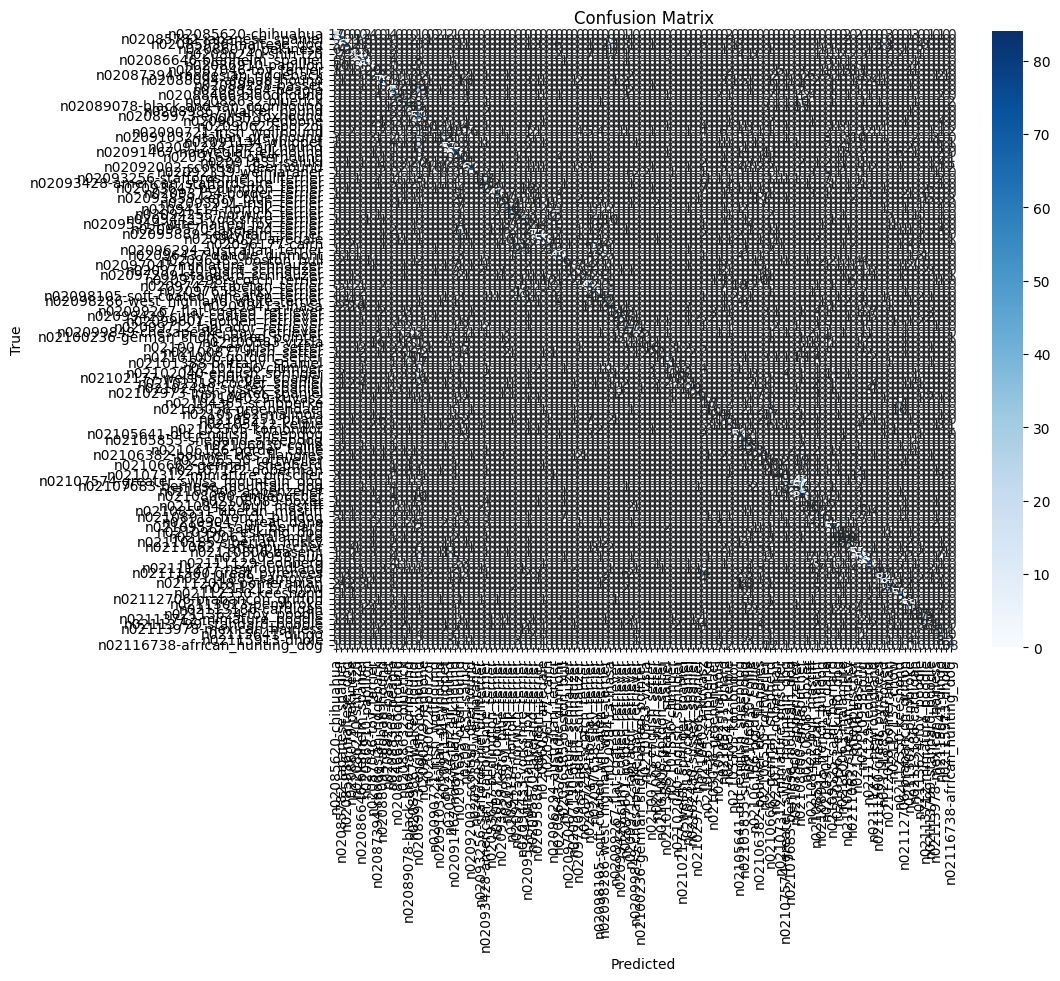

In [ ]:
conf_matrix_inceptionv3 = confusion_matrix(y_true_inceptionv3, y_pred_inceptionv3)

# Print classification report with class names
print("Classification Report:")
print(classification_report(y_true_inceptionv3, y_pred_inceptionv3, target_names=class_names))

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_inceptionv3, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## WRITE UP
The models that were chosen for this classification dataset are: Resnet, Alexnet, custom model and InceptionV3 model. The Mobilenet model and VGG model were not included because we do not require feature extraction and this model is not for mobiel applications. Categorical crossentropy was used as the loss function as it is best suited for multi-class classification problems. Early stopping and

Various Combinations tested:

*   The model were created using variations in Pooling and Dense layers. The
Dropout layers was added to combat overfitting.
*   The Adam optimizer was used as it performed better than RMSProp optimizer.
*   The learning schedule was created using Exponential Deacy to test a range of learning rates with the optimizer.
*   Different layers for the model were unfrozen so that the model would adapt well to the dataset and pick up more nuances.
*   The batch size of 64 and 32 were tested and 64 gave the better result.
*   Number of epochs were kept to 20 and early stopping was used to prevent overfitting.
*   The image shape was tested: first 32x32 and then 244x244. the bigger shape gives better results.

Problems faced and resolved:

*   The model would crash when batch size of 128 was used or if the model was fitted to the entire dataset so batch size 64 was used.
*   Data Augmentation was attempted but the system crashed even with batch 32 and a less complex model. Could not overcome this challenge.
*   The Custom model performed badly and it is difficult to improve their accuracy. Focus was given to pre-learned models as they are more likeyly to perform better.
*   The validation accuracy is very low. Early stopping and Dropout layers were used to reduce overfitting.
*   Very Difficult to test different combinations of parameters as run time is very long, system crashes if GPU usage becomes too high and Colab takes away GPU access based on unclear/dynamic requirements. I had to use another google account to regain T4 GPU access.

Evaluation of model performance:
The model only has an accuracy of 0.42 for the test dataset while it showed an accuracy of upto 93% for the training dataset. This means that the model is overfitting on the training dataset.
According to the Classification Report, the model is reasonably good at predicting some of the dogs such as Papillion but in most cases it does not perform well.  

What worked well:
Adding the learning schedule and the unfreezing the layers to improve the model training accuracy. The addition of the Dropout layer and early Stopping helped with the validation accuracy to a degree. 























